In [1]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import networkx as nx
import netwulf as nw
from itertools import combinations
from collections import defaultdict
import random
from scipy import stats
from networkx.algorithms import community
import community

seed = 1337
random.seed(seed)
np.random.seed(seed)

In [2]:
song_data = pd.read_pickle('songData.df')
print(f'Number of songs: {len(song_data)}')

Number of songs: 25419


In [3]:
all_artists = set()
for artists in song_data.artists:
    all_artists = all_artists.union(set(artists))
print(f'Number of artists: {len(all_artists)}')

Number of artists: 7855


In [4]:
song_data.head()

,released,artists,lyrics,genres,title
0,1957,[marty robbins],\nOut in the West Texas town of El Paso\nI fel...,[country],El Paso
1,1960-01-04,[frankie avalon],I'll never let you go\nWhy? Because I love you...,[pop],Why
3,1959,[johnny preston],"On the bank of the river\nStood Running Bear, ...",[pop],Running Bear
4,1960-01-04,[freddy cannon],"Well, way down yonder in New Orleans\nIn the l...",[pop],Way Down Yonder in New Orleans
5,1960-01-04,[guy mitchell],"\nHeartaches by the number, troubles by the sc...","[country, cover]",Heartaches by the Number


## Create the network (graph)

In [5]:
all_artists = set()
artist_genres = dict()
artist_genres_count = defaultdict(lambda: defaultdict(lambda: 0))
for artists, genres in zip(song_data.artists, song_data.genres):
    for artist in artists:
        all_artists = all_artists.union(set([artist]))
        for genre in genres:
            artist_genres_count[artist][genre] += 1
        if artist in artist_genres.keys():
            artist_genres[artist] = artist_genres[artist].union(set(genres))
        else:
            artist_genres[artist] = set(genres)
        

all_artists = list(all_artists)
print(f'Number of unique artists: {len(all_artists)}')

Number of unique artists: 7855


In [6]:
genre_list = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul', 
              'singer-songwriter', 'pop-rock', 'trap', 'ballad', 
             'soul pop', 'eighties', 'uk', 'seventies', 'soundtrack',
             'hip-hop', 'funk', 'dance', 'electronic', 'folk', 'cover', 
             'jazz', 'blues']

In [7]:
colour_list = ['#E74C3C', '#9B59B6', '#3498DB', '#1ABC9C', '#27AE60', '#F4D03F', '#E67E22', '#EDB9B9', '#E7E9B9',
              '#B9EDE0', '#B9D7ED', '#DCB9ED', '#8F2323', '#8F6A23', '#4F8F23', '#23628F', '#6B238F', '#AED6F1',
              '#A3E4D7', '#D4AC0D', '#D7BDE2', '#F5B7B1', '#0A2ADA', '#DA0A8D']

In [8]:
colour_dict = {}
for colour, genre in zip(colour_list, genre_list+['other']):
    colour_dict[genre] = colour

In [9]:
artist_count = defaultdict(lambda: 0)
artist_colab_count = defaultdict(lambda: defaultdict(lambda: 0))

for artists in song_data.artists:
    for artist in artists:
        artist_count[artist] += 1
        for colab in artists:
            if colab != artist:
                artist_colab_count[artist][colab] += 1

### Add nodes
Add each artist as a node with three attributes
> *genre*: most common genre for that artist within the fixed list 'genre_list'

> *size*: number of times the artist has appeared on Billboard's the hot 100 (used to give each node the correct size)

> *all_genres*: all genres associated with that artist

In [10]:
G = nx.Graph()
for artist in all_artists:
    most_occurences = 0
    max_key = 'other'
    random.shuffle(genre_list)
    
    for genre in genre_list:
        if genre in artist_genres_count[artist]:
            if artist_genres_count[artist][genre] > most_occurences:
                most_occurences = artist_genres_count[artist][genre]
                max_key = genre
                
    G.add_node(artist, genre=max_key, 
               size=artist_count[artist], 
               all_genres=artist_genres[artist], 
               group=colour_dict[max_key])
    
G.number_of_nodes()

7855

### Add edges
Add edges between two artists if they have collaborated on a song

In [11]:
linked_artists = set()
for artists in song_data.artists:
    if len(artists) > 1:
        for comb in combinations(artists, 2):
            if not comb[0] == comb[1]:
                linked_artists = linked_artists.union({tuple([comb[0], comb[1], artist_colab_count[comb[0]][comb[1]]])})

linked_artists = list(linked_artists)
print(f'Number of edges: {len(linked_artists)}')

Number of edges: 7098


In [12]:
G.add_weighted_edges_from(linked_artists)
G.number_of_edges()

6799

## Helper functions

In [13]:
def randomized_graph(graph, N):
    g = graph.copy()
    swaps = 0
    while swaps < N:
        uv = random.choice(list(g.edges()))
        if uv[0] == uv[1]:
            uv = random.choice(list(g.edges()))
        xy = random.choice(list(g.edges()))
        while uv[1] == xy[0]:
            xy = random.choice(list(g.edges()))
        if not g.has_edge(uv[0], xy[1]) and not g.has_edge(uv[1], xy[0]):
            g.remove_edges_from([uv, xy])
            g.add_edges_from([(uv[0], xy[1]), (uv[1], xy[0])])
            swaps += 1
    return g

In [14]:
def get_network_by_genre(G, genre):
    genre_nodes = [node for node, data in G.nodes(data=True) if genre in data['all_genres']]
    return G.subgraph(genre_nodes)

In [15]:
def get_partitioning(filtered_graph):
    partitioning = []
    nc = set(nx.get_node_attributes(filtered_graph, 'group').values())
    for i in nc:
        nodes = (
            node
            for node, data
            in filtered_graph.nodes(data=True)
            if data.get("group") == i
        )
        partitioning.append(filtered_graph.subgraph(nodes))
    return partitioning

In [16]:
def modularity(graph, partitioning):
    M = 0
    L = graph.number_of_edges()
    for subgraph in partitioning:
        Lc = subgraph.number_of_edges()
        kc = sum(graph.degree[node] for node in subgraph.nodes())
        M += Lc/L - (kc / (2 * L))**2
    return M

## The full network

> Without singletons

In [17]:
G_no_singles = G.copy()
for artist, data in G.nodes(data=True):
    if G_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_no_singles.remove_node(artist)

In [18]:
print(f'Number of nodes: {G_no_singles.number_of_nodes()}')
print(f'Number of edges: {G_no_singles.number_of_edges()}')

Number of nodes: 4154
Number of edges: 6799


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 51128)
Traceback (most recent call last):
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\http\server.py", line 705, in send_head
    f = open(path, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Kristoffer\\.netwulf\\favicon.ico'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_a

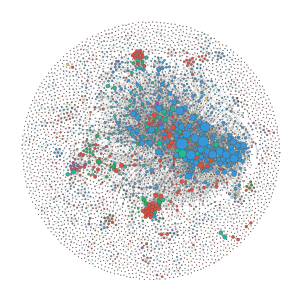

In [19]:
network_G_no_singles, config = nw.visualize(G_no_singles, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_no_singles)
plt.savefig("network_figures/G_no_singles.pdf")

In [22]:
import json

with open('../networks/complete/network.json', 'w') as fp:
    json.dump(network_G_no_singles, fp)

with open('../networks/complete/config.json', 'w') as fp:
    json.dump(config, fp)

In [21]:
config

{'zoom': 1,
 'node_charge': -22.72841175288562,
 'node_gravity': 0.6315918557288625,
 'link_distance': 15,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#79aaa0',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 24.15201243158621,
 'node_stroke_width': 1,
 'node_size_variation': 0.5,
 'link_color': '#7c7c7c',
 'link_width': 3.5814734491996276,
 'link_alpha': 0.7875710431808577,
 'link_width_variation': 0.5,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

In [22]:
import json

with open('../networks/complete/network.json', 'w') as fp:
    json.dump(nx.node_link_data(G_no_singles), fp)


TypeError: Object of type set is not JSON serializable

### Properties

In [72]:
graph = G_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 4154
Number of Links: 6799
Density: 0.00079
Avg. clustering: 0.30
Average degrees: 3.27
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 108


> With singletons

### Visualisation

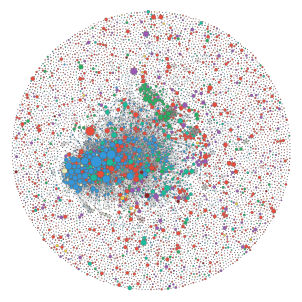

In [71]:
network_G, _ = nw.visualize(G, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G)
plt.savefig("network_figures/G.pdf")

### Properties

In [201]:
print(f'Number of Nodes: {G.number_of_nodes()}')
print(f'Number of Links: {G.number_of_edges()}')
print(f'Density: {nx.density(G):.5f}')
print(f'Avg. clustering: {nx.average_clustering(G):.2f}')
degrees = list(dict(G.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 7855
Number of Links: 6799
Density: 0.00022
Avg. clustering: 0.16
Average degrees: 1.73
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 108


In [202]:
sorted_degrees = {k: v for k, v in sorted(dict(G.degree()).items(), key=lambda item: item[1], reverse=True)}

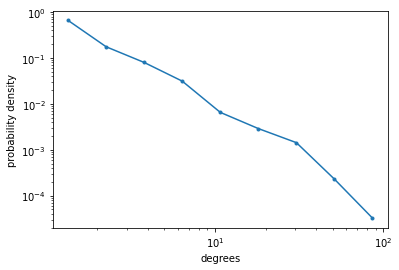

In [203]:
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [204]:
con_com = nx.algorithms.connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
gia_com = G.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.97818


### Community detection

In [217]:
genre_partitioning = get_partitioning(G)

In [221]:
print(f'Genre partitioning modularity: {modularity(G, a):.4f}')

Genre partitioning modularity: 0.3178


In [222]:
network_modularity = community.modularity(community.best_partition(G), G)

In [223]:
print(f'Modularity for the full network: {network_modularity:.4f}')

Modularity for the full network: 0.7481


#### Building random network for comparison

In [24]:
RG = randomized_graph(G, int(G.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(G.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 13598
Degree in random graph: 13598


In [48]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(G, int(G.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [49]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.02353317533848245
Standard deviation of modularity: 0.0030683111776214802


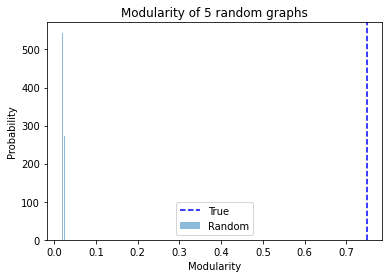

In [54]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Pop network

In [73]:
genre = 'pop'
G_pop = get_network_by_genre(G, genre)

In [74]:
for artist, data in G_pop.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

> Without singletons

In [75]:
G_pop_no_singles = G_pop.copy()
for artist, data in G_pop.nodes(data=True):
    if G_pop_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_pop_no_singles.remove_node(artist)

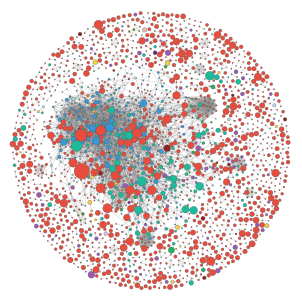

In [77]:
network_G_pop_no_singles, _ = nw.visualize(G_pop_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop_no_singles)
plt.savefig("network_figures/G_pop_no_singles.pdf")

### Properties

In [79]:
graph = G_pop_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2218
Number of Links: 3907
Density: 0.00159
Avg. clustering: 0.22
Average degrees: 3.52
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 74


> With singletons

### Visualisation

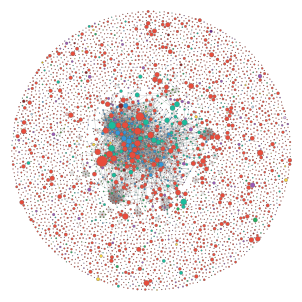

In [80]:
# network_G_pop, config = nw.visualize(G_pop, plot_in_cell_below=True)
network_G_pop, _ = nw.visualize(G_pop, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_pop)
plt.savefig("network_figures/G_pop.pdf")

### Properties

In [81]:
graph = G_pop
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 4802
Number of Links: 3907
Density: 0.00034
Avg. clustering: 0.10
Average degrees: 1.63
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 74


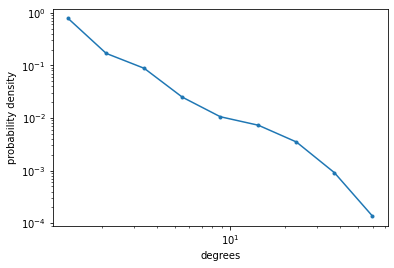

In [78]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [79]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.70743


### Community detection

In [80]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [81]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.7103


#### Building random network for comparison

In [66]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 7814
Degree in random graph: 7814


In [67]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [68]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.01427826476717545
Standard deviation of modularity: 0.006407161123978455


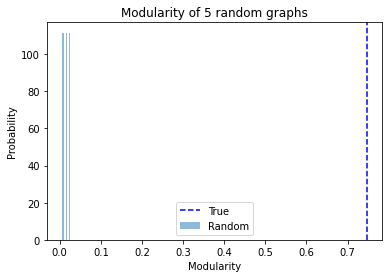

In [69]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Rap network

In [82]:
genre = 'rap'
G_rap = get_network_by_genre(G, genre)

In [83]:
for artist, data in G_rap.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

> Without singletons

In [86]:
G_rap_no_singles = G_rap.copy()
for artist, data in G_rap.nodes(data=True):
    if G_rap_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_rap_no_singles.remove_node(artist)

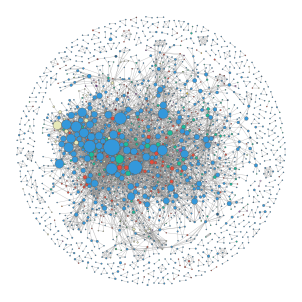

In [87]:
network_G_rap_no_singles, _ = nw.visualize(G_rap_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_rap_no_singles)
plt.savefig("network_figures/G_rap_no_singles.pdf")

### Properties

In [88]:
graph = G_pop_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2218
Number of Links: 3907
Density: 0.00159
Avg. clustering: 0.22
Average degrees: 3.52
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 74


> With singletons

### Visualisation

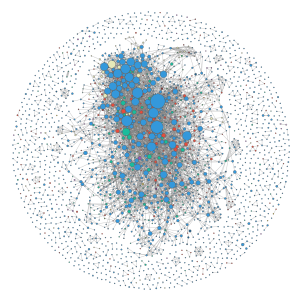

In [89]:
network_G_rap, _ = nw.visualize(G_rap, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_rap)
plt.savefig("network_figures/G_rap.pdf")

### Properties

In [85]:
graph = G_rap
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2481
Number of Links: 4495
Density: 0.00146
Avg. clustering: 0.33
Average degrees: 3.62
Median degrees: 2.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 108


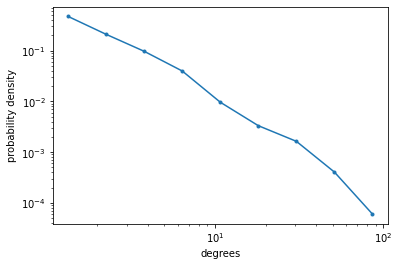

In [86]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [87]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.18619


### Community detection

In [88]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [89]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.6282


#### Building random network for comparison

In [90]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 8990
Degree in random graph: 8990


In [91]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [92]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.0055803444935109015
Standard deviation of modularity: 0.0019465755598867711


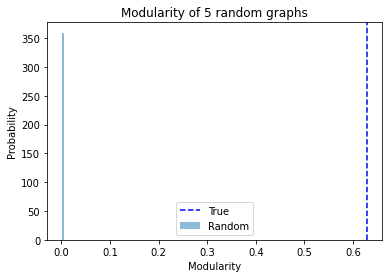

In [93]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Rock network

In [90]:
genre = 'rock'
G_rock = get_network_by_genre(G, genre)

In [91]:
for artist, data in G_rock.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

> Without singletons

In [92]:
G_rock_no_singles = G_rock.copy()
for artist, data in G_rock.nodes(data=True):
    if G_rock_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_rock_no_singles.remove_node(artist)

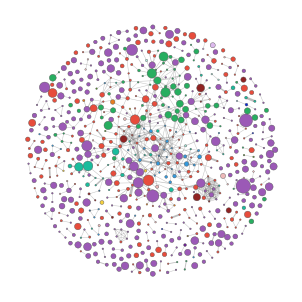

In [93]:
network_G_rock_no_singles, _ = nw.visualize(G_rock_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_rock_no_singles)
plt.savefig("network_figures/G_rock_no_singles.pdf")

### Properties

In [94]:
graph = G_pop_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2218
Number of Links: 3907
Density: 0.00159
Avg. clustering: 0.22
Average degrees: 3.52
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 74


> With singletons

### Visualisation

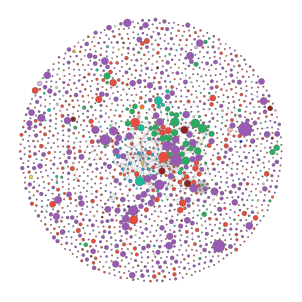

In [95]:
network_G_rock, _ = nw.visualize(G_rock, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_rock)
plt.savefig("network_figures/G_rock.pdf")

### Properties

In [97]:
graph = G_rock
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 1812
Number of Links: 768
Density: 0.00047
Avg. clustering: 0.07
Average degrees: 0.85
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 19


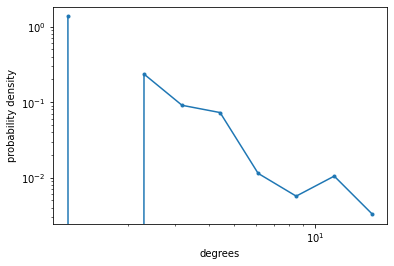

In [98]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [99]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 5.19514


### Community detection

In [100]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [101]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.8534


#### Building random network for comparison

In [102]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 1536
Degree in random graph: 1536


In [103]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [104]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.012597825792100678
Standard deviation of modularity: 0.004730703678277333


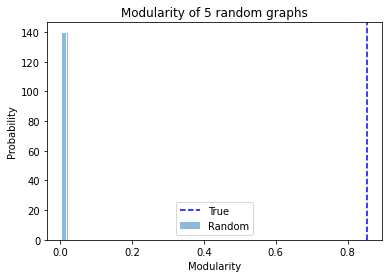

In [105]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## R&B network

In [97]:
genre = 'r&b'
G_RB = get_network_by_genre(G, genre)

In [98]:
for artist, data in G_RB.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

> Without singletons

In [99]:
G_RB_no_singles = G_RB.copy()
for artist, data in G_RB.nodes(data=True):
    if G_RB_no_singles.degree(artist) == 0 and data['size'] < 5:
        G_RB_no_singles.remove_node(artist)

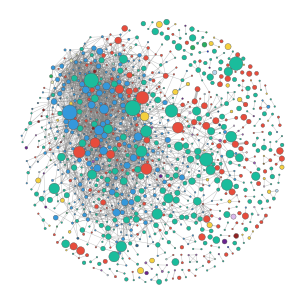

In [100]:
network_G_RB_no_singles, _ = nw.visualize(G_RB_no_singles, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_RB_no_singles)
plt.savefig("network_figures/G_RB_no_singles.pdf")

### Properties

In [101]:
graph = G_pop_no_singles
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 2218
Number of Links: 3907
Density: 0.00159
Avg. clustering: 0.22
Average degrees: 3.52
Median degrees: 1.0
Mode of degrees: 1
Minimum degree: 0
Maximum degree: 74


> With singletons

### Visualisation

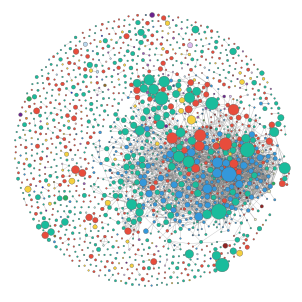

In [102]:
network_G_RB, _ = nw.visualize(G_RB, config=config, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network_G_RB)
plt.savefig("network_figures/G_RB.pdf")

### Properties

In [109]:
graph = G_RB
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 1631
Number of Links: 2657
Density: 0.00200
Avg. clustering: 0.16
Average degrees: 3.26
Median degrees: 1.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 83


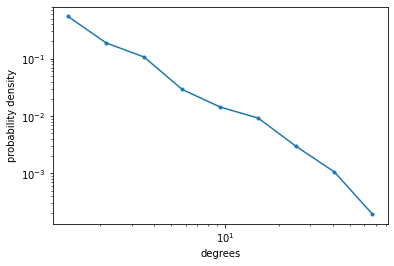

In [110]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [111]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.10817


### Community detection

In [112]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [113]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.5425


#### Building random network for comparison

In [114]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 5314
Degree in random graph: 5314


In [115]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [116]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.003285744092942944
Standard deviation of modularity: 0.0040015156522399675


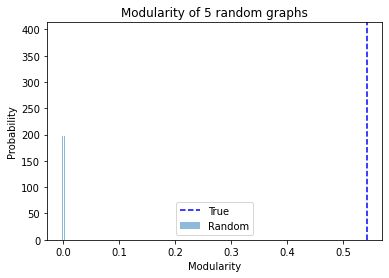

In [117]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Country network

In [19]:
genre = 'country'
G_country = get_network_by_genre(G, genre)

In [20]:
for artist, data in G_country.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### Visualisation

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 60398)
Traceback (most recent call last):
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\http\server.py", line 647, in __init__
    super().__init__(*args, **kwargs)
  File "c:\users\kristoffer\appdata\local\programs\python\python38\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "c:\users\kristoffer\appdata\local\programs\py

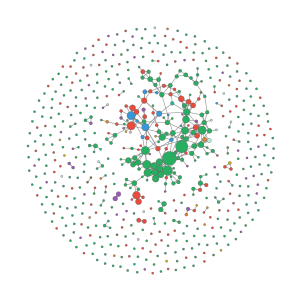

In [21]:
network_G_country, config = nw.visualize(G_country, plot_in_cell_below=True)

In [23]:
import json

with open('../networks/test/country/network.json', 'w') as fp:
    json.dump(network_G_country, fp)

with open('../networks/test/country/config.json', 'w') as fp:
    json.dump(config, fp)

### Properties

In [121]:
graph = G_country
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 622
Number of Links: 340
Density: 0.00176
Avg. clustering: 0.09
Average degrees: 1.09
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 19


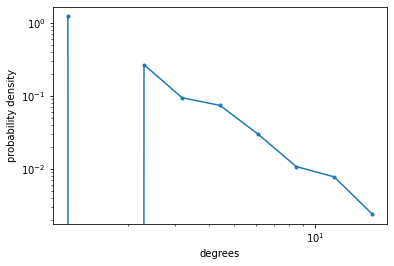

In [122]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [123]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.72255


### Community detection

In [124]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [125]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.7959


#### Building random network for comparison

In [126]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 680
Degree in random graph: 680


In [127]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [128]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.00842560553633211
Standard deviation of modularity: 0.011616716269489118


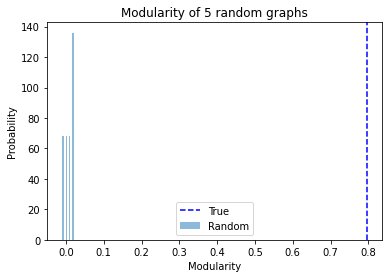

In [129]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Soul network

In [130]:
genre = 'soul'
G_soul = get_network_by_genre(G, genre)

In [131]:
for artist, data in G_soul.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### Visualisation

In [132]:
# network_G_soul, config = nw.visualize(G_soul, plot_in_cell_below=True)

### Properties

In [133]:
graph = G_soul
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 721
Number of Links: 756
Density: 0.00291
Avg. clustering: 0.12
Average degrees: 2.10
Median degrees: 1.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 32


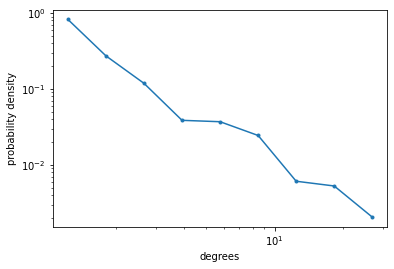

In [134]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [135]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.09309


### Community detection

In [136]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [137]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.6575


#### Building random network for comparison

In [138]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 1512
Degree in random graph: 1512


In [139]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [140]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: -0.0024917065591668727
Standard deviation of modularity: 0.011304688158318253


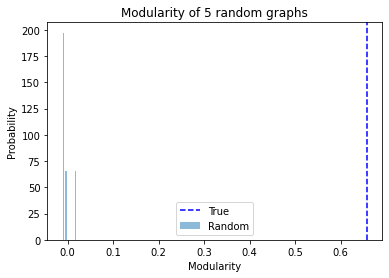

In [141]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Singer-songwriter network

In [142]:
genre = 'singer-songwriter'
G_SS = get_network_by_genre(G, genre)

In [143]:
for artist, data in G_SS.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### Visualisation

In [144]:
# network_G_SS, config = nw.visualize(G_SS, plot_in_cell_below=True)

### Properties

In [145]:
graph = G_SS
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 561
Number of Links: 565
Density: 0.00360
Avg. clustering: 0.12
Average degrees: 2.01
Median degrees: 1.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 25


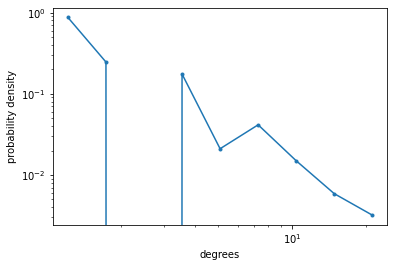

In [146]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [147]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 4.36970


### Community detection

In [148]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [149]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.7054


#### Building random network for comparison

In [150]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 1130
Degree in random graph: 1130


In [151]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [152]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.02658313102044013
Standard deviation of modularity: 0.013617971017112464


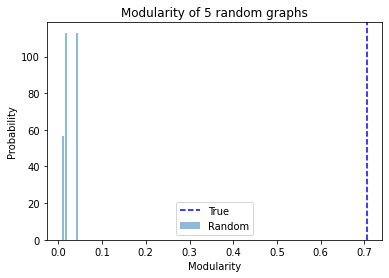

In [153]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Electronic network

In [154]:
genre = 'electronic'
G_electronic = get_network_by_genre(G, genre)

In [155]:
for artist, data in G_electronic.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### Visualisation

In [156]:
# network_G_electronic, config = nw.visualize(G_electronic, plot_in_cell_below=True)

### Properties

In [157]:
graph = G_electronic
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 422
Number of Links: 884
Density: 0.00995
Avg. clustering: 0.22
Average degrees: 4.19
Median degrees: 2.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 43


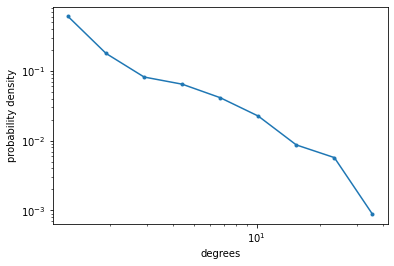

In [158]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [159]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 3.46060


### Community detection

In [160]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [161]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.4622


#### Building random network for comparison

In [162]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 1768
Degree in random graph: 1768


In [163]:
modularity_list = []
N = 5
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [164]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: 0.00966580332098033
Standard deviation of modularity: 0.020091211107957762


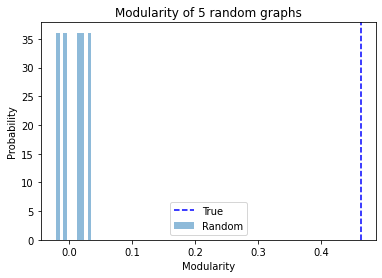

In [165]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()

## Folk network

In [166]:
genre = 'folk'
G_folk = get_network_by_genre(G, genre)

In [167]:
for artist, data in G_folk.nodes(data=True):
    data['size'] = artist_genres_count[artist][genre]

### Visualisation

In [168]:
# network_G_folk, config = nw.visualize(G_folk, plot_in_cell_below=True)

### Properties

In [169]:
graph = G_folk
print(f'Number of Nodes: {graph.number_of_nodes()}')
print(f'Number of Links: {graph.number_of_edges()}')
print(f'Density: {nx.density(graph):.5f}')
print(f'Avg. clustering: {nx.average_clustering(graph):.2f}')
degrees = list(dict(graph.degree()).values())
print(f'Average degrees: {np.mean(degrees):.2f}')
print(f'Median degrees: {np.median(degrees)}')
print(f'Mode of degrees: {stats.mode(degrees)[0][0]}')
print(f'Minimum degree: {min(degrees)}')
print(f'Maximum degree: {max(degrees)}')

Number of Nodes: 159
Number of Links: 47
Density: 0.00374
Avg. clustering: 0.07
Average degrees: 0.59
Median degrees: 0.0
Mode of degrees: 0
Minimum degree: 0
Maximum degree: 7


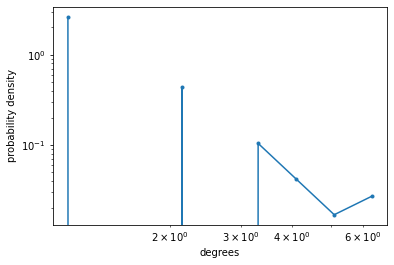

In [170]:
sorted_degrees = {k: v for k, v in sorted(dict(graph.degree()).items(), key=lambda item: item[1], reverse=True)}
#bins = np.linspace(min(degrees), max(degrees), 10)
bins = np.logspace(0, np.log10(max(degrees)), 10)
density = True
hist, edges = np.histogram(degrees, bins=bins, density = density)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, ax = plt.subplots()
#ax.bar(x, hist, width=width_rand*0.9)
ax.plot(x, hist, marker='.')

ax.set_xlabel('degrees')
if density:
    ax.set_ylabel('probability density')
else:
    ax.set_ylabel('counts')
    
ax.set_yscale("log")
ax.set_xscale("log")

In [171]:
con_com = nx.algorithms.connected_components(graph)
largest_cc = max(nx.connected_components(graph), key=len)
gia_com = graph.subgraph(largest_cc)
avg_sho_pat_len = nx.average_shortest_path_length(gia_com)
print(f'Avg. shortest path length: {avg_sho_pat_len:.5f}')

Avg. shortest path length: 3.30000


### Community detection

In [172]:
network_modularity = community.modularity(community.best_partition(graph), graph)

In [173]:
print(f'Louvain modularity for the full network: {network_modularity:.4f}')

Louvain modularity for the full network: 0.8444


#### Building random network for comparison

In [178]:
RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
print(f'Degree in original graph: {sum(dict(graph.degree).values())}')
print(f'Degree in random graph: {sum(dict(RG.degree).values())}')

Degree in original graph: 94
Degree in random graph: 94


In [180]:
modularity_list = []
N = 1000
for _ in range(N):
    RG = randomized_graph(graph, int(graph.number_of_edges()*1.2))
    new_RG = nw.get_filtered_network(RG, node_group_key='group')
    RG_partitioning = get_partitioning(new_RG)
    modularity_list.append(modularity(RG, RG_partitioning))

In [181]:
print(f'Average modularity: {np.mean(modularity_list)}')
print(f'Standard deviation of modularity: {np.std(modularity_list)}')

Average modularity: -0.004254866455409681
Standard deviation of modularity: 0.05608920254308685


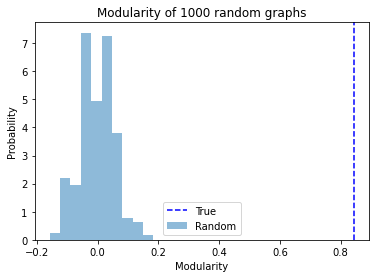

In [182]:
plt.hist(modularity_list, alpha=0.5, label='Random', density=True)
plt.axvline(network_modularity, color = 'b', linestyle='--', label='True')
plt.legend()
plt.title(f'Modularity of {N} random graphs')
plt.xlabel('Modularity')
plt.ylabel('Probability')
plt.show()